# Multilabel Classification with TF-IDF and Naive Bayes

This notebook demonstrates a multilabel text classification task using TF-IDF for feature extraction and Naive Bayes for classification. The dataset used is a CSV file with descriptions and tags.


## Libraries and Dependencies

In [102]:
import pandas as pd
import torch
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

## Loading the Data
Read the CSV file containing the data.

In [103]:
df=pd.read_csv('codeforce_processed_cleaned_data_.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,time_limit,memory_limit,input_file,output_file,description,tags,language
0,0,1846/F,1 second,256 megabytes,standard,standard,interactive task rudolph a scientist study ali...,"['constructive algorithms', 'implementation', ...",en
1,1,1847/D,2 seconds,256 megabytes,standard,standard,josuke tire peaceful life morioh follow nephew...,"['data structures', 'dsu', 'greedy', 'implemen...",en
2,2,1846/E2,2 seconds,256 megabytes,standard,standard,hard version problem difference version $$$ n ...,"['binary search', 'brute force', 'data structu...",en
3,3,1846/E1,2 seconds,256 megabytes,standard,standard,a simple version problem difference version $$...,"['brute force', 'implementation', 'math']",en
4,4,1846/C,1 second,256 megabytes,standard,standard,rudolf register a program competition follow r...,"['constructive algorithms', 'greedy', 'impleme...",en


## TF-IDF Vectorization
Use `TfidfVectorizer` to convert the text descriptions into numerical features.

In [104]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['description'])
X.shape

(7950, 1000)

## Preprocessing the Tags
Convert the `tags` column from strings to lists.

In [105]:
import ast

tags = df['tags'].tolist()
for i in range(len(tags)):
    tags[i] = str(tags[i])

df['tags'] = [ast.literal_eval(tag) for tag in tags]

## Binarizing the Tags
Use `MultiLabelBinarizer` to convert the tags into a binary format.

In [106]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['tags'])

## Train-Test Split
Split the data into training and testing sets.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training
Train a `MultinomialNB` classifier using `OneVsRestClassifier`.

In [108]:
nb= MultinomialNB()

classifier = OneVsRestClassifier(nb)
classifier.fit(X_train, y_train)

X_train.shape

(6360, 1000)

## Predictions
Make predictions on the test set.

In [109]:
y_pred = classifier.predict(X_test)
y_pred.shape

(1590, 37)

Ensure that each text has at least one tag predicted.

In [110]:
for i in range(y_pred.shape[0]):
    if not y_pred[i].any():
        # Assign the most probable tag
        y_pred[i, np.argmax(classifier.predict_proba(X_test[i]))] = 1

## Evaluation
Evaluate the model using various metrics.

In [111]:
report=classification_report(y_test, y_pred, zero_division= 0, target_names=mlb.classes_,output_dict=True)
avgs=['weighted avg', 'macro avg', 'micro avg', 'samples avg']
report_df = pd.DataFrame(report).transpose()

In [112]:
for index_name in avgs:
    row = report_df.loc[index_name]
    print(f"{index_name.capitalize()} Metrics:")
    for metric_name, value in row.items():
        print(f"  {metric_name.capitalize()}: {value:.2f}")
    print()

Weighted avg Metrics:
  Precision: 0.50
  Recall: 0.24
  F1-score: 0.28
  Support: 4445.00

Macro avg Metrics:
  Precision: 0.32
  Recall: 0.12
  F1-score: 0.15
  Support: 4445.00

Micro avg Metrics:
  Precision: 0.56
  Recall: 0.24
  F1-score: 0.33
  Support: 4445.00

Samples avg Metrics:
  Precision: 0.55
  Recall: 0.27
  F1-score: 0.34
  Support: 4445.00



In [113]:
report_df.drop(avgs, axis=0, inplace=True)
report_df

,precision,recall,f1-score,support
*special,0.000000,0.000000,0.000000,47.0
2-sat,0.000000,0.000000,0.000000,3.0
binary search,1.000000,0.005714,0.011364,175.0
bitmasks,1.000000,0.021978,0.043011,91.0
brute force,0.000000,0.000000,0.000000,242.0
chinese remainder theorem,0.000000,0.000000,0.000000,3.0
combinatorics,0.666667,0.018868,0.036697,106.0
constructive algorithms,0.774194,0.083045,0.150000,289.0
data structures,0.672727,0.129371,0.217009,286.0
dfs and similar,0.541667,0.356164,0.429752,146.0


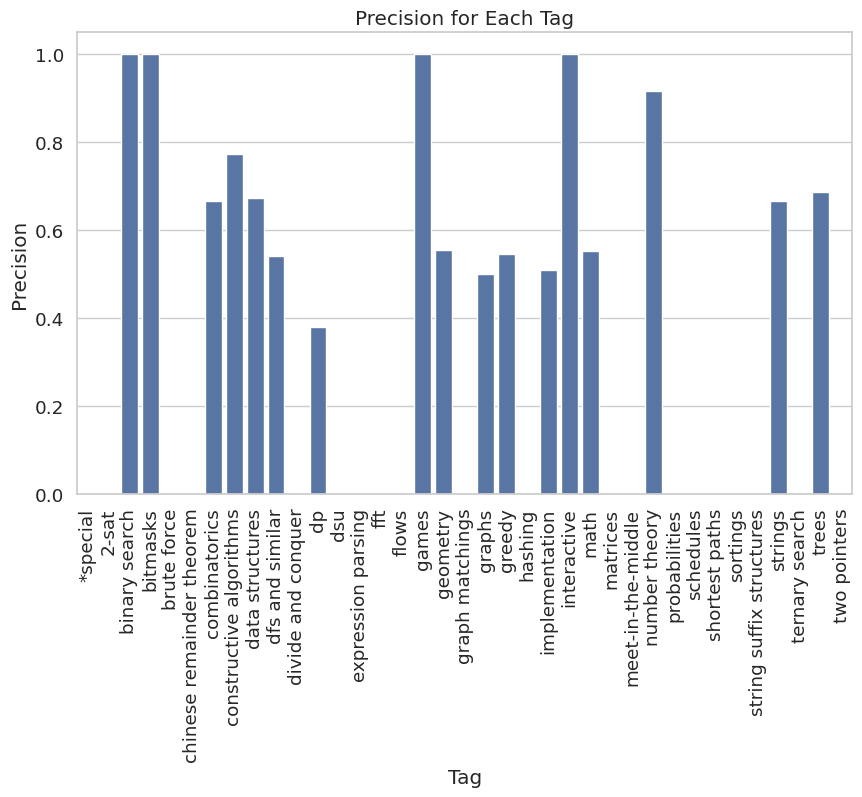

In [114]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='precision', data=report_df)
plt.xticks(rotation=90)
plt.title('Precision for Each Tag')
plt.xlabel('Tag')
plt.ylabel('Precision')
plt.show()

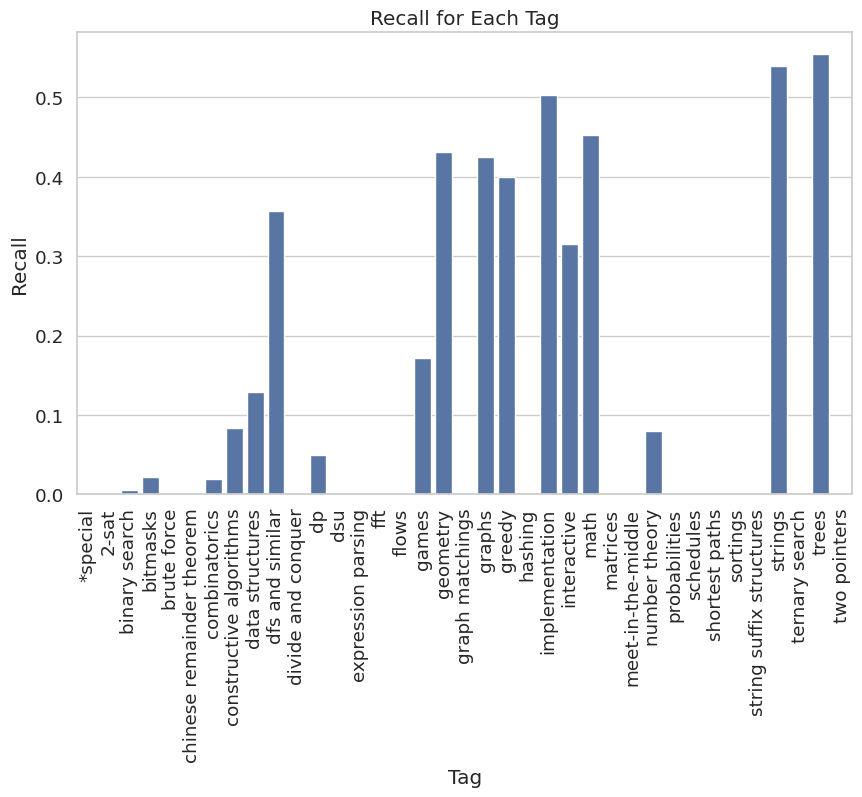

In [115]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='recall', data=report_df)
plt.xticks(rotation=90)
plt.title('Recall for Each Tag')
plt.xlabel('Tag')
plt.ylabel('Recall')
plt.show()

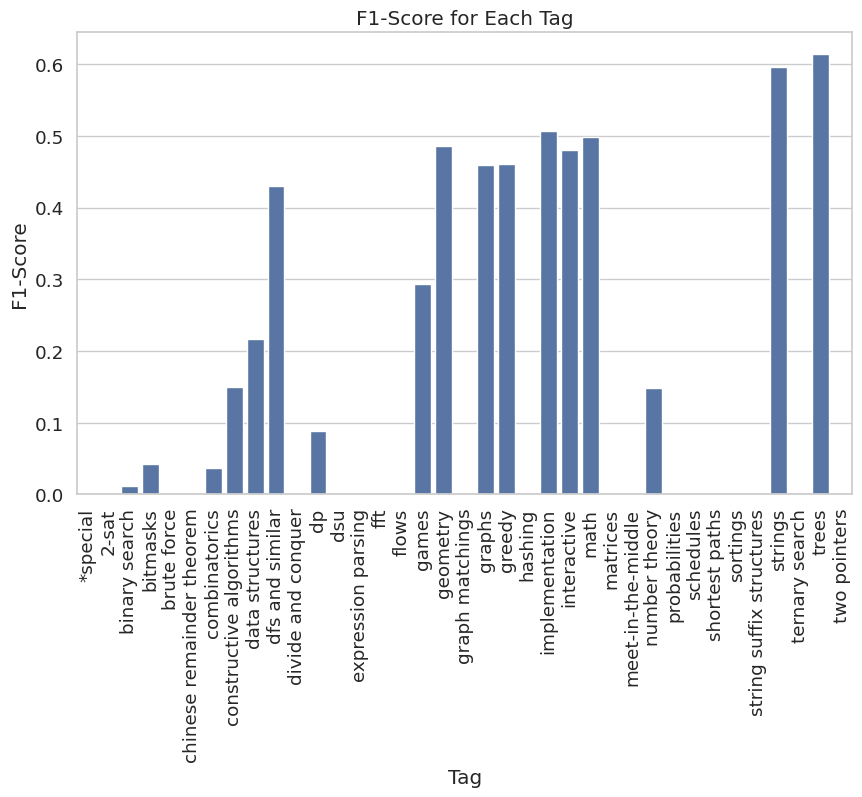

In [116]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='f1-score', data=report_df)
plt.xticks(rotation=90)
plt.title('F1-Score for Each Tag')
plt.xlabel('Tag')
plt.ylabel('F1-Score')
plt.show()

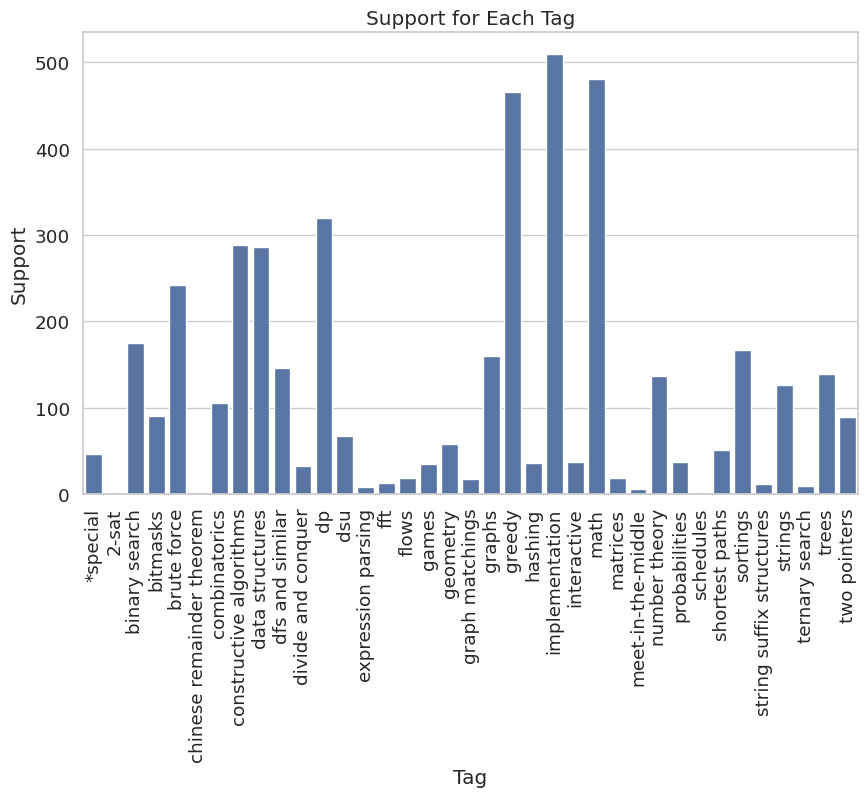

In [117]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='support', data=report_df)
plt.xticks(rotation=90)
plt.title('Support for Each Tag')
plt.xlabel('Tag')
plt.ylabel('Support')
plt.show()

In [118]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Overall Accuracy: 7.61%


In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

dic={}
for i, class_name in enumerate(mlb.classes_):
    dic[class_name]=i

def plot_confusion_matrix(class_name):
    '''
    Plot the confusion matrix for the specified class.
    '''
    cm = confusion_matrix(y_test[:, dic[class_name]], y_pred[:, dic[class_name]])
    labels = ['False', 'True']
    sns.heatmap(cm, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()


# Plot confusion matrix for each class
interact(plot_confusion_matrix, class_name=Dropdown(options=mlb.classes_, description='Select Class:'))

interactive(children=(Dropdown(description='Select Class:', options=('*special', '2-sat', 'binary search', 'bi…

<function __main__.plot_confusion_matrix(class_name)>